In this notebook, we will use LSTM to predict stock price (more precisely, we are interested in the rise and fall of a stock price based on previous information) in Keras. I will also use more than one feature in my model, and it could be interesting for you to see how we can create the LSTM input data shape required by Keras in this case.

Moreover, we are going to implement a manual Grid Search to tune the hyperparameters. We will also take advantage of Early Stopping and Callback to reduce the hyperparameter tunning time. To the best of my knowledge, the tunned model has the best result on this data in the Kaggle.

## Contents

* [Import Libraries and the Data](#1)
* [Descriptive Analysis](#2)
    - [Number of unique stock symbols](#21)
    - [Choosing a Random Stock Symbol](#22)
    - [plotting Price through Time](#23)
    - [Fearure Scaling](#24)
    - [Creating LSTM input data](#25)
* [Train LSTM Model](#3)
* [Hyperparameter Tunning](#4)
    - [Introduction](#41)
    - [Grid Search](#42)
    - [Early Stopping and Callback](#43)
    - [Choosing the Best Model](#44)
* [Results](#5)

<a id="1"></a> <br>
## Import Libraries and the Data

In [3]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import itertools
import random
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nyse/prices-split-adjusted.csv
/kaggle/input/nyse/fundamentals.csv
/kaggle/input/nyse/prices.csv
/kaggle/input/nyse/securities.csv


In [4]:
data =  pd.read_csv('../input/nyse/prices.csv', header=0)

<a id="2"></a> <br>
## Descriptive Analysis

In [5]:
data.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05 00:00:00,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06 00:00:00,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07 00:00:00,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08 00:00:00,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11 00:00:00,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [6]:
print(data.columns)
print(data.shape)

Index(['date', 'symbol', 'open', 'close', 'low', 'high', 'volume'], dtype='object')
(851264, 7)


In [7]:
data.iloc[:, 2:-1].describe()

,open,close,low,high
count,851264.000000,851264.000000,851264.000000,851264.000000
mean,70.836986,70.857109,70.118414,71.543476
std,83.695876,83.689686,82.877294,84.465504
min,0.850000,0.860000,0.830000,0.880000
25%,33.840000,33.849998,33.480000,34.189999
50%,52.770000,52.799999,52.230000,53.310001
75%,79.879997,79.889999,79.110001,80.610001
max,1584.439941,1578.130005,1549.939941,1600.930054


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    851264 non-null  object 
 1   symbol  851264 non-null  object 
 2   open    851264 non-null  float64
 3   close   851264 non-null  float64
 4   low     851264 non-null  float64
 5   high    851264 non-null  float64
 6   volume  851264 non-null  float64
dtypes: float64(5), object(2)
memory usage: 45.5+ MB


<a id="21"></a> <br>
## Number of unique stock symbols

In [9]:
print(len(data['symbol'].unique()))
symbols = data['symbol'].unique()

501


In [10]:
data['symbol'].describe()

count     851264
unique       501
top          FIS
freq        1762
Name: symbol, dtype: object

<a id="22"></a> <br>
## Choosing a Random Stock Symbol

In [11]:
# random.seed(42)  #explain!
choosen_symbol = random.choice(symbols)
print(choosen_symbol)

PXD


In [17]:
data_prices = data[data['symbol'] == choosen_symbol].reset_index(drop = True)
data_prices.iloc[:10, :]

,date,symbol,open,close,low,high,volume
0,2010-01-04,PXD,49.380001,50.980000,49.380001,51.150002,1524100.0
1,2010-01-05,PXD,51.060001,51.000000,50.790001,51.779999,1666100.0
2,2010-01-06,PXD,51.000000,51.889999,50.560001,52.369999,2130300.0
3,2010-01-07,PXD,51.389999,52.349998,50.290001,52.689999,1491400.0
4,2010-01-08,PXD,51.599998,53.250000,51.380001,53.349998,1374800.0
5,2010-01-11,PXD,53.700001,52.279999,51.750000,54.029999,1214400.0
6,2010-01-12,PXD,51.290001,51.139999,50.759998,51.990002,1345700.0
7,2010-01-13,PXD,51.459999,51.900002,49.930000,52.000000,1302700.0
8,2010-01-14,PXD,51.689999,52.529999,51.509998,52.700001,794000.0
9,2010-01-15,PXD,52.279999,50.529999,50.189999,52.680000,2090300.0


In [18]:
data_prices = data_prices.drop(['date', 'symbol'], axis=1)

<a id="23"></a> <br>
## Plotting Price through Time

While the first big plot shows opening, closing, low, and high price altogether, the following four plots show each attribute separately. It may seem that all of the mentioned prices are the same, but as it is clear in the first big plot, they have a slight difference with each other.

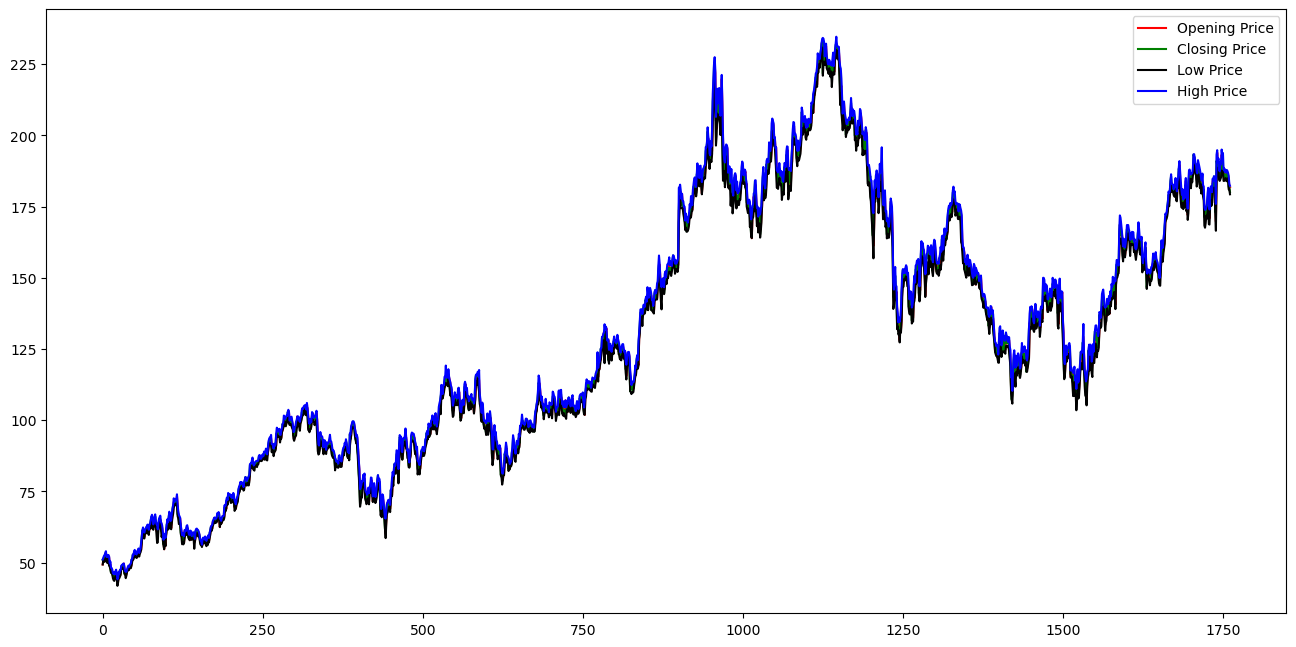

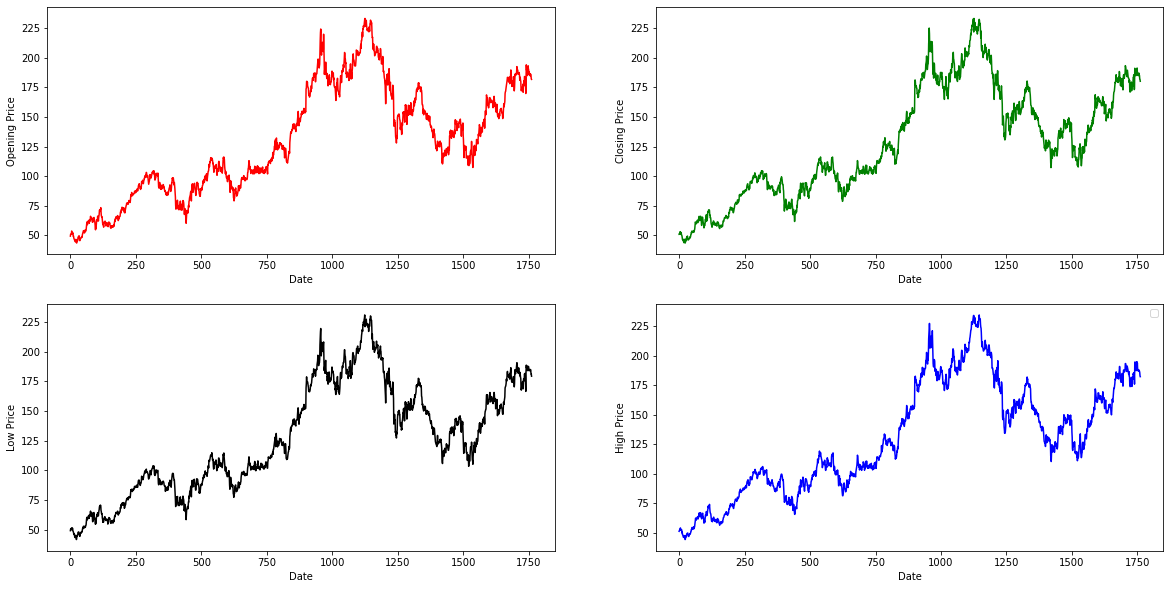

In [19]:
plt.figure(figsize=(16,8), dpi= 100, facecolor='w', edgecolor='k')

plt.plot(data_prices['open'], color='red', label = 'Opening Price')
plt.plot(data_prices['close'], color='green', label = 'Closing Price')
plt.plot(data_prices['low'], color='black', label = 'Low Price')
plt.plot(data_prices['high'], color='blue', label = 'High Price')
plt.legend(loc='best')

plt.subplots(2, 2, figsize = (20, 10))

ax1 = plt.subplot(2, 2, 1)
plt.plot(data_prices['open'], color='red')
plt.xlabel('Date')
plt.ylabel('Opening Price')

ax2 = plt.subplot(2, 2, 2)
plt.plot(data_prices['close'], color='green')
plt.xlabel('Date')
plt.ylabel('Closing Price')

ax3 = plt.subplot(2, 2, 3)
plt.plot(data_prices['low'], color='black')
plt.xlabel('Date')
plt.ylabel('Low Price')

ax4 = plt.subplot(2, 2, 4)
plt.plot(data_prices['high'], color='blue')
plt.xlabel('Date')
plt.ylabel('High Price')

plt.legend(loc='best')

We choose the opening price and volume as two attributes to consider in our model.

In [20]:
data_prices = data_prices.drop(['close', 'low', 'high'], axis=1)

In [22]:
data_prices.head()

,open,volume
0,49.380001,1524100.0
1,51.060001,1666100.0
2,51.000000,2130300.0
3,51.389999,1491400.0
4,51.599998,1374800.0


<a id="24"></a> <br>
## Feature Scaling

In [23]:
# Feature Scaling
sc = MinMaxScaler(feature_range=(0, 1))
data_prices_scaled = sc.fit_transform(data_prices)

In [24]:
data_prices_scaled.shape

(1762, 2)

<a id="25"></a> <br>
## Creating LSTM input data

In order to use LSTM, our input and output data should have a specific shape. It was a bit complicated for me when I was first introduced to LSTM, but I found [this](https://medium.com/@shivajbd/understanding-input-and-output-shape-in-lstm-keras-c501ee95c65e) comprehensive article to fully understand what was going on. In a nutshell, the input and output data in an LSTM model is a three-dimensional array where the first dimension represents **the number of samples (or batch size)** like the number of rows of data in a two-dimensional setting, the second dimension stands for **time steps** which indicates the amount of time that we want to go back through time, and the third dimension shows **the number of features (or input dimension)** that we want to include in the model for every element in our batch. So, it is like [number_of_samples, time_steps, input_dim]. The below image is retrieved from the mentioned article and could be a good illustration of the LSTM input and output data shape.
![](https://miro.medium.com/max/665/1*AQKRJsRdWx2HZ85H1yWoKw.png)

Sometimes we prefer to choose the validation set by ourselves. In this case, in the below code, you can pass a value in the range of (0, 1) for the validation_split_percentage when you are calling the create_data function, and use the below code to fit the model:

- model.fit(train_X, train_y, validation_data=(val_x, val_y))  # manually splitting

In my case, I rathered to use the built-in parameter (validation_split) in the fit method of the Keras library.  It considers a fraction of the training data as the validation set to evaluate loss and metrics at the end of each epoch as follow:

- model.fit(train_X, train_y, validation_split=0.3)  # automatically splitting

Here, at each point of the time, we will consider price and volume as our attributes in input_dim, and 25 days as our time_steps.

In [25]:
# Creating a data structure (it does not work when you have only one feature)
def create_data(df, n_future, n_past, train_test_split_percentage, validation_split_percentage):
    n_feature = df.shape[1]
    x_data, y_data = [], []
    
    for i in range(n_past, len(df) - n_future + 1):
        x_data.append(df[i - n_past:i, 0:n_feature])
        y_data.append(df[i + n_future - 1:i + n_future, 0])
    
    split_training_test_starting_point = int(round(train_test_split_percentage*len(x_data)))
    split_train_validation_starting_point = int(round(split_training_test_starting_point*(1-validation_split_percentage)))
    
    x_train = x_data[:split_train_validation_starting_point]
    y_train = y_data[:split_train_validation_starting_point]
    
    # if you want to choose the validation set by yourself, uncomment the below code.
    x_val = x_data[split_train_validation_starting_point:split_training_test_starting_point]
    y_val =  x_data[split_train_validation_starting_point:split_training_test_starting_point]                                             
    
    x_test = x_data[split_training_test_starting_point:]
    y_test = y_data[split_training_test_starting_point:]
    
    return np.array(x_train), np.array(x_test), np.array(x_val), np.array(y_train), np.array(y_test), np.array(y_val)

In [26]:
# Number of days you want to predict into the future
# Number of past days you want to use to predict the future

X_train, X_test, X_val, y_train, y_test, y_val = create_data(data_prices_scaled, n_future=1, n_past=25, train_test_split_percentage=0.8,
                                               validation_split_percentage = 0)

In [27]:
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(1390, 25, 2)
(347, 25, 2)
(1390, 1)
(347, 1)


<a id="3"></a> <br>
## Train LSTM Model

In [28]:
# ------------------LSTM-----------------------
regressor = Sequential()
regressor.add(LSTM(units=16, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=16, return_sequences=False))
regressor.add(Dropout(0.2))
regressor.add(Dense(units=1, activation='linear'))
regressor.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 25, 16)            1216      
_________________________________________________________________
dropout (Dropout)            (None, 25, 16)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 3,345
Trainable params: 3,345
Non-trainable params: 0
_________________________________________________________________


In [29]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
#mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# fit model
history = regressor.fit(X_train, y_train, validation_split=0.3, epochs=40, batch_size=64, callbacks=[es])

Epoch 1/40
16/16 [==============================] - 1s 85ms/step - loss: 0.0907 - root_mean_squared_error: 0.3012 - val_loss: 0.1559 - val_root_mean_squared_error: 0.3948
Epoch 2/40
16/16 [==============================] - 0s 29ms/step - loss: 0.0242 - root_mean_squared_error: 0.1555 - val_loss: 0.0236 - val_root_mean_squared_error: 0.1537
Epoch 3/40
16/16 [==============================] - 0s 26ms/step - loss: 0.0112 - root_mean_squared_error: 0.1057 - val_loss: 0.0157 - val_root_mean_squared_error: 0.1253
Epoch 4/40
16/16 [==============================] - 0s 28ms/step - loss: 0.0061 - root_mean_squared_error: 0.0782 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0601
Epoch 5/40
16/16 [==============================] - 0s 26ms/step - loss: 0.0054 - root_mean_squared_error: 0.0737 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0558
Epoch 6/40
16/16 [==============================] - 0s 28ms/step - loss: 0.0045 - root_mean_squared_error: 0.0672 - val_loss: 0.0024 - val_root_m

In [30]:
history.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

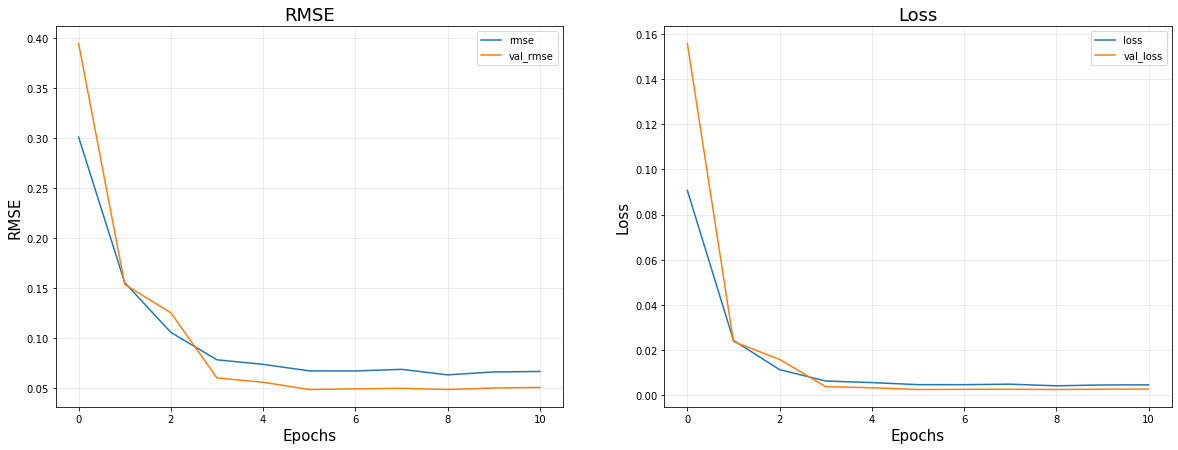

In [31]:
fig = plt.figure(figsize=(20,7))
fig.add_subplot(121)

# Accuracy
plt.plot(history.epoch, history.history['root_mean_squared_error'], label = "rmse")
plt.plot(history.epoch, history.history['val_root_mean_squared_error'], label = "val_rmse")

plt.title("RMSE", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("RMSE", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()


#Adding Subplot 1 (For Loss)
fig.add_subplot(122)

plt.plot(history.epoch, history.history['loss'], label="loss")
plt.plot(history.epoch, history.history['val_loss'], label="val_loss")

plt.title("Loss", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

In [32]:
results = regressor.evaluate(X_test, y_test)
print("test loss, test acc:", np.round(results, 4))

11/11 [==============================] - 0s 6ms/step - loss: 0.0030 - root_mean_squared_error: 0.0547
test loss, test acc: [0.003  0.0547]


In [24]:
data.tail()

,date,symbol,open,close,low,high,volume
851259,2016-12-30,ZBH,103.309998,103.199997,102.849998,103.930000,973800.0
851260,2016-12-30,ZION,43.070000,43.040001,42.689999,43.310001,1938100.0
851261,2016-12-30,ZTS,53.639999,53.529999,53.270000,53.740002,1701200.0
851262,2016-12-30 00:00:00,AIV,44.730000,45.450001,44.410000,45.590000,1380900.0
851263,2016-12-30 00:00:00,FTV,54.200001,53.630001,53.389999,54.480000,705100.0


In [33]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [34]:
# Feature engineering - create lagged features
lags = [1, 2, 3, 4, 5]  # Define lag values for creating lagged features

for lag in lags:
    data[f'close_lag_{lag}'] = data['close'].shift(lag)


In [35]:
# Remove rows with NaN values resulting from lagging
data.dropna(inplace=True)
# Define features and target variable
features = ['open', 'low', 'high', 'volume'] + [f'close_lag_{lag}' for lag in lags]
target = 'close'

In [36]:
X = data[features]
y = data[target]

In [37]:
def create_data_for_xgboost(df, n_future, n_past, train_test_split_percentage):
    x_data, y_data = [], []

    for i in range(n_past, len(df) - n_future + 1):
        x_data.append(df[i - n_past:i])
        y_data.append(df[i + n_future - 1, 0])  # Assuming the target variable is the first column (index 0)

    split_index = int(train_test_split_percentage * len(x_data))

    x_train = x_data[:split_index]
    y_train = y_data[:split_index]

    x_test = x_data[split_index:]
    y_test = y_data[split_index:]

    return np.array(x_train), np.array(x_test), np.array(y_train), np.array(y_test)

# Number of days you want to predict into the future
n_future = 1
# Number of past days you want to use to predict the future
n_past = 25
# Train-test split percentage
train_test_split_percentage = 0.8

X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = create_data_for_xgboost(data_prices_scaled, n_future, n_past, train_test_split_percentage)


In [38]:
# Define XGBoost parameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

In [39]:
# Flatten the 3D array into a 2D array
X_train_xgb_flat = X_train_xgb.reshape(X_train_xgb.shape[0], -1)
X_test_xgb_flat = X_test_xgb.reshape(X_test_xgb.shape[0], -1)

In [40]:
# Convert data into DMatrix format
dtrain_xgb = xgb.DMatrix(X_train_xgb_flat, label=y_train_xgb)
dtest_xgb = xgb.DMatrix(X_test_xgb_flat, label=y_test_xgb)

In [41]:
# Train XGBoost model
num_round = 100
xgb_model = xgb.train(params, dtrain_xgb, num_round)

In [42]:
# Make predictions
y_pred_xgb = xgb_model.predict(dtest_xgb)

In [43]:
# Evaluate the XGBoost model
rmse_xgb = np.sqrt(mean_squared_error(y_test_xgb, y_pred_xgb))
print("XGBoost RMSE:", rmse_xgb)

XGBoost RMSE: 0.023524647407436892


Here, we observe that LSTM has a higher RMSE than XGBoost.

<a id="4"></a> <br>
## Hyperparameter Tunning


We have two important terms in machine learning referred to as **model parameter** and **model hyperparamer**. So, first of all, what is a hyperparameter, and what is a parameter? Based on [here](https://www.datacamp.com/community/tutorials/parameter-optimization-machine-learning-models),

- A model **model hyperparameter** is a configuration that is external to the model and whose value cannot be estimated from the data and a **model parameter** is a configuration variable that is internal to the model and whose value can be estimated from the given data.

In the other words, a hyperparameter is used to construct the structure of the model and cannot be learned from the data and its value is set before the learning process begins. Therefore, hyperparameters are like the settings of an algorithm that can be adjusted to optimize performance and prevent overfitting. This is exactly what we do in the hyperparameter tuning. We try to choose a set of optimal hyperparameters for a learning algorithm to enhance the performance of the model. There are two frequently used methods to perform hyperparameter tunning called 1)Grid Search and 2)Random Search. In this notebook, I have used the former one because of its simplicity to implement and at the same time, its powerful performance. More information on both of the methods can be found in [here](https://blog.usejournal.com/a-comparison-of-grid-search-and-randomized-search-using-scikit-learn-29823179bc85).

<a id="42"></a> <br>
## Grid Search

Grid search is a traditional method to perform hyperparameter tunning. It basically works by defining a subset of candidate values for each hyperparameter, and training all the possible combination of the hyperparameters. Then, each possible fitted model is evaluated on a validation set, and the best configuration of the hyperparameter will be choosed at the end.

<a id="43"></a> <br>
## Early Stopping and Callback

Since in the Grid Search, we have to train an LSTM model for each combination, it may take so much time to fit all the models and choose the best combination of the hyperparameters. One of the ways that we can prevent this from happening is through using Early Stopping and Callbacks. The idea here is to track a measure (like validation loss) and whenever a stopping criterion (like no improvement in the monitored measure value in successive steps, reaching a pre-specified limit for that measure, or a pre-specified increment in that measure) is satisfied, we can stop the training process. The measure that we are using here is validation loss since the validation set is not used in the training process. [This](https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/) article is one of the best articles that I've read about using Early Stopping to halt the training of a model at the right time. In the below, I copied and pasted the parts that I found important:

> 1. **es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)** ****-->**** Often, the first sign of no further improvement may not be the best time to stop training. This is because the model may coast into a plateau of no improvement or even get slightly worse before getting much better. We can account for this by adding a delay to the trigger in terms of the number of epochs on which we would like to see no improvement. This can be done by setting the “patience” argument.
    
> 2. **es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1)** **-->** By default, any change in the performance measure, no matter how fractional, will be considered an improvement. You may want to consider an improvement that is a specific increment, such as 1 unit for mean squared error or 1% for accuracy. This can be specified via the “min_delta” argument.

> 3. **es = EarlyStopping(monitor='val_loss', mode='min', baseline=0.4)** **-->**  Finally, it may be desirable to only stop training if performance stays above or below a given threshold or baseline. For example, if you have familiarity with the training of the model (e.g. learning curves) and know that once a validation loss of a given value is achieved that there is no point in continuing training. This can be specified by setting the “baseline” argument.
    
> 4. **mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1)** **-->** The EarlyStopping callback will stop training once triggered, but the model at the end of training may not be the model with best performance on the validation dataset. An additional callback is required that will save the best model observed during training for later use. This is the ModelCheckpoint callback.

In [44]:
# detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)


def LSTM_HyperParameter_Tuning(config, x_train, y_train, x_test, y_test):
    
    first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = config
    possible_combinations = list(itertools.product(first_additional_layer, second_additional_layer, third_additional_layer,
                                                  n_neurons, n_batch_size, dropout))
    
    print(possible_combinations)
    print('\n')
    
    hist = []
    
    for i in range(0, len(possible_combinations)):
        
        print(f'{i+1}th combination: \n')
        print('--------------------------------------------------------------------')
        
        first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = possible_combinations[i]
        
        # instantiating the model in the strategy scope creates the model on the TPU
        #with tpu_strategy.scope():
        regressor = Sequential()
        regressor.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
        regressor.add(Dropout(dropout))

        if first_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if second_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if third_additional_layer:
            regressor.add(GRU(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        regressor.add(LSTM(units=n_neurons, return_sequences=False))
        regressor.add(Dropout(dropout))
        regressor.add(Dense(units=1, activation='linear'))
        regressor.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        '''''
        From the mentioned article above --> If a validation dataset is specified to the fit() function via the validation_data or v
        alidation_split arguments,then the loss on the validation dataset will be made available via the name “val_loss.”
        '''''

        file_path = 'best_model.h5'

        mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

        '''''
        cb = Callback(...)  # First, callbacks must be instantiated.
        cb_list = [cb, ...]  # Then, one or more callbacks that you intend to use must be added to a Python list.
        model.fit(..., callbacks=cb_list)  # Finally, the list of callbacks is provided to the callback argument when fitting the model.
        '''''

        regressor.fit(x_train, y_train, validation_split=0.3, epochs=40, batch_size=n_batch_size, callbacks=[es, mc], verbose=0)

        # load the best model
        # regressor = load_model('best_model.h5')

        train_accuracy = regressor.evaluate(x_train, y_train, verbose=0)
        test_accuracy = regressor.evaluate(x_test, y_test, verbose=0)

        hist.append(list((first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout,
                          train_accuracy, test_accuracy)))

        print(f'{str(i)}-th combination = {possible_combinations[i]} \n train accuracy: {train_accuracy} and test accuracy: {test_accuracy}')
        
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
         
    return hist

In [45]:
config = [[False], [False], [False], [16, 32], [8, 16, 32], [0.2]]  

# list of lists --> [[first_additional_layer], [second_additional_layer], [third_additional_layer], [n_neurons], [n_batch_size], [dropout]]

hist = LSTM_HyperParameter_Tuning(config, X_train, y_train, X_test, y_test)  # change x_train shape

[(False, False, False, 16, 8, 0.2), (False, False, False, 16, 16, 0.2), (False, False, False, 16, 32, 0.2), (False, False, False, 32, 8, 0.2), (False, False, False, 32, 16, 0.2), (False, False, False, 32, 32, 0.2)]


1th combination: 

--------------------------------------------------------------------

Epoch 00001: val_loss improved from inf to 0.00377, saving model to best_model.h5

Epoch 00002: val_loss improved from 0.00377 to 0.00242, saving model to best_model.h5

Epoch 00003: val_loss did not improve from 0.00242

Epoch 00004: val_loss improved from 0.00242 to 0.00170, saving model to best_model.h5

Epoch 00005: val_loss improved from 0.00170 to 0.00167, saving model to best_model.h5

Epoch 00006: val_loss did not improve from 0.00167

Epoch 00007: val_loss improved from 0.00167 to 0.00159, saving model to best_model.h5

Epoch 00008: val_loss improved from 0.00159 to 0.00156, saving model to best_model.h5

Epoch 00009: val_loss did not improve from 0.00156

Epoch 00010: val_los

<a id="44"></a> <br>
## Choosing the Best Model

In [46]:
hist = pd.DataFrame(hist)
hist = hist.sort_values(by=[7], ascending=True)
hist

,0,1,2,3,4,5,6,7
5,False,False,False,32,32,0.2,"[0.0009420637506991625, 0.03069305792450905]","[0.0012436358956620097, 0.03526522219181061]"
4,False,False,False,32,16,0.2,"[0.0009395421948283911, 0.03065195307135582]","[0.0017082348931580782, 0.04133079946041107]"
0,False,False,False,16,8,0.2,"[0.0016994512407109141, 0.0412244014441967]","[0.0017698798328638077, 0.0420699380338192]"
1,False,False,False,16,16,0.2,"[0.0012456972617655993, 0.035294435918331146]","[0.0018722888780757785, 0.04326995462179184]"
3,False,False,False,32,8,0.2,"[0.0012597718741744757, 0.035493265837430954]","[0.0020317393355071545, 0.04507482051849365]"
2,False,False,False,16,32,0.2,"[0.0024857616517692804, 0.04985741153359413]","[0.002471366198733449, 0.04971283674240112]"


<a id="5"></a> <br>
## Results

In [47]:
print(f'Best Combination: \n first_additional_layer = {hist.iloc[0, 0]}\n second_additional_layer = {hist.iloc[0, 1]}\n third_additional_layer = {hist.iloc[0, 2]}\n n_neurons = {hist.iloc[0, 3]}\n n_batch_size = {hist.iloc[0, 4]}\n dropout = {hist.iloc[0, 5]}')
print('**************************')
print(f'Results Before Tunning:\n Test Set RMSE: {np.round(results, 4)[1]}\n')
print(f'Results After Tunning:\n Test Set RMSE: {np.round(hist.iloc[0, -1], 4)[1]}\n')
print(f'{np.round((results[1] - hist.iloc[0, -1][1])*100/np.round(results, 4)[1])}% Improvement')

Best Combination: 
 first_additional_layer = False
 second_additional_layer = False
 third_additional_layer = False
 n_neurons = 32
 n_batch_size = 32
 dropout = 0.2
**************************
Results Before Tunning:
 Test Set RMSE: 0.0547

Results After Tunning:
 Test Set RMSE: 0.0353

36.0% Improvement


In [48]:
first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = list(hist.iloc[0, :-2])

In [49]:
regressor = Sequential()
regressor.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(dropout))

if first_additional_layer:
    regressor.add(LSTM(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

if second_additional_layer:
    regressor.add(LSTM(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

if third_additional_layer:
    regressor.add(GRU(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

regressor.add(LSTM(units=n_neurons, return_sequences=False))
regressor.add(Dropout(dropout))
regressor.add(Dense(units=1, activation='linear'))
regressor.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

file_path = 'best_model.h5'

mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

regressor.fit(X_train, y_train, validation_split=0.3, epochs=40, batch_size=n_batch_size, callbacks=[es, mc], verbose=0)


Epoch 00001: val_loss improved from inf to 0.00757, saving model to best_model.h5

Epoch 00002: val_loss improved from 0.00757 to 0.00211, saving model to best_model.h5

Epoch 00003: val_loss did not improve from 0.00211

Epoch 00004: val_loss improved from 0.00211 to 0.00209, saving model to best_model.h5

Epoch 00005: val_loss improved from 0.00209 to 0.00204, saving model to best_model.h5

Epoch 00006: val_loss did not improve from 0.00204

Epoch 00007: val_loss improved from 0.00204 to 0.00181, saving model to best_model.h5

Epoch 00008: val_loss did not improve from 0.00181

Epoch 00009: val_loss did not improve from 0.00181

Epoch 00010: val_loss did not improve from 0.00181

Epoch 00011: val_loss did not improve from 0.00181

Epoch 00012: val_loss improved from 0.00181 to 0.00166, saving model to best_model.h5

Epoch 00013: val_loss did not improve from 0.00166

Epoch 00014: val_loss did not improve from 0.00166

Epoch 00015: val_loss did not improve from 0.00166

Epoch 00016: 

In [50]:
regressor.evaluate(X_test, y_test)

11/11 [==============================] - 0s 7ms/step - loss: 9.7575e-04


0.0009757482912391424

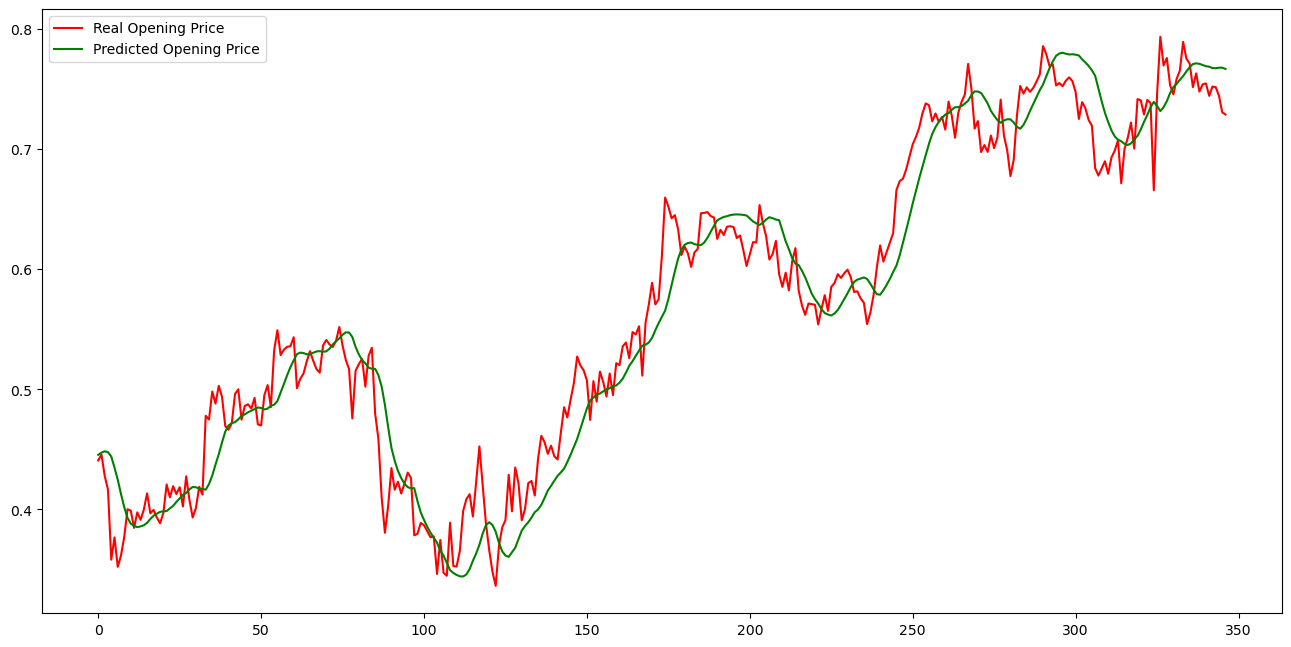

In [51]:
y_pred = regressor.predict(X_test)

plt.figure(figsize=(16,8), dpi= 100, facecolor='w', edgecolor='k')

plt.plot(y_test, color='red', label = 'Real Opening Price')
plt.plot(y_pred, color='green', label = 'Predicted Opening Price')
plt.legend(loc='best')

In [55]:
# Reshape the input data to remove the time dimension
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Fit the grid search to the reshaped data
grid_search.fit(X_train_reshaped, y_train)

# Print the best parameters found
print("Best parameters found: ", grid_search.best_params_)

# Get the best estimator
best_xgb_reg = grid_search.best_estimator_

# Predictions on test set
y_pred_best = best_xgb_reg.predict(X_test_reshaped)

# Evaluate the model
mse_best = mean_squared_error(y_test, y_pred_best)
print("Mean Squared Error on test set (after tuning): ", mse_best)


Fitting 5 folds for each of 729 candidates, totalling 3645 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   57.3s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 19.0min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 25.8min
[Parallel(n_jobs=-1)]: Done 3645 out of 3645 | elapsed: 29.5min finished


Best parameters found:  {'colsample_bytree': 1.0, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300}
Mean Squared Error on test set (after tuning):  0.00042682172640368815


In [56]:
# Calculate Root Mean Squared Error
rmse_best = np.sqrt(mse_best)

print("Root Mean Squared Error (RMSE) on test set (after tuning): ", rmse_best)

Root Mean Squared Error (RMSE) on test set (after tuning):  0.020659664237438327


As it is clear in the plot, the trend (rise and fall) of the stock price is well predicted. Nice!